In [ ]:
!wget https://github.com/ChanCheeKean/datasets/blob/main/compressed/hourly_electricity.zip?raw=true
!unzip hourly_electricity.zip?raw=true
!pip install pytorch_forecasting

In [40]:
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# 1) Deep Transformer Model

https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e

## 1.1 Masking

* **Padding masking**. When using sequences of different lengths (sentences would normally be of different lengths), sequences shorter than the selected maximum sequence length (this is a hyperparameter than can have any value, e.g. 50) will be padded with a padding token. The padding tokens must be masked to prevent the model from attending to these tokens.

* **Decoder input masking** (aka “look ahead masking”). This type of masking prevents the decoder from attending to future tokens when it “considers” what “meaning” token t has.

In [ ]:
### generate mask
def generate_square_subsequent_mask(dim1: int, dim2: int):
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

### process data
def get_src_trg(
    sequence: torch.Tensor, 
    enc_seq_len: int, 
    target_seq_len: int
    ):

    """
    Generate the src (encoder input), trg (decoder input) and trg_y (the target)
    sequences from a sequence. 
    Args:
        sequence: tensor, a 1D tensor of length n where n = encoder input length + target sequence length  
        enc_seq_len: int, the desired length of the input to the transformer encoder
        target_seq_len: int, the desired length of the target sequence
    Return: 
        src: tensor, 1D, used as input to the transformer model
        trg: tensor, 1D, used as input to the transformer model
        trg_y: tensor, 1D, the target sequence against which the model output
            is compared when computing loss. 
    
    """
    # encoder input
    src = sequence[:, :enc_seq_len] 
    
    # decoder input. it must have the same dimension as the target sequence
    # values of trg_y except the last (i.e. it must be shifted right by 1)
    trg = sequence[:, enc_seq_len - 1 : sequence.size(1) - 1]
    trg = trg[:, :, 0]
    
    # The target sequence against which the model output will be compared to compute loss
    trg_y = sequence[:, -target_seq_len:]

    # to consist of the target variable not any potential exogenous variables
    trg_y = trg_y[:, :, 0]

    # # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 
    return src, trg.unsqueeze(-1), trg_y.unsqueeze(-1)

### testing, num feature = 1
src, trg, trg_y = get_src_trg(
    sequence=torch.rand(62, 15, 1),
    enc_seq_len=10, 
    target_seq_len=5
    )

print(f"src Size: {src.size()}")
print(f"trg Size: {trg.size()}")
print(f"trg_y Size: {trg_y.size()}")

src Size: torch.Size([62, 10, 1])
trg Size: torch.Size([62, 5, 1])
trg_y Size: torch.Size([62, 5, 1])


In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        ):

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        # pe.size = (1, 5000, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### testing
pos_embedder = PositionalEncoder()
batch_size, seq_len, d_model = 32, 10, 512
result = pos_embedder(torch.rand(batch_size, seq_len, d_model))
print(f"Result Size: {result.size()}")

Result Size: torch.Size([32, 10, 512])


In [ ]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model.
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, #neurons in the middle linear layer of the encoder
            dim_feedforward_decoder: int, #neurons in the middle linear layer of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 
        # the length of the input sequence fed to the decoder
        self.dec_seq_len = dec_seq_len

        # Creating the three linear layers needed for the model
        self.encoder_linear = nn.Linear(
            in_features=input_size, 
            out_features=dim_val)
        
        self.decoder_linear = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val)  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features)

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=True
            )

        # Stack the encoder layers in nn.TransformerDecoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=True
            )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(
        self, 
        src: torch.Tensor, 
        tgt: torch.Tensor, 
        src_mask: torch.Tensor=None, 
        tgt_mask: torch.Tensor=None
        ) -> torch.Tensor:

        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (m, S, E) where S is the source sequence length, 
                 m is the batch size, and E is the number of features (1 if univariate)

            tgt: the sequence to the decoder. Shape: (m, T, E) where T is the target sequence length, 
                 m is the batch size, and E is the number of features (1 if univariate)

            src_mask: the mask for the src sequence to prevent the model from using data points

            tgt_mask: the mask for the tgt sequence to prevent the model from using data points
        """

        # [m, in_seq, num_feat] --> [m, in_seq, dim_val]
        src = self.encoder_linear(src) 
        src = self.positional_encoding_layer(src) 
        
        # Pass through all the stacked encoder layers in the encoder, mask needed if padded
        # [m, in_seq, dim_val]
        encoder_output = self.encoder(src=src)

        # Pass decoder input through decoder input layer
        # [m, out_seq, num_feat] --> [m, out_seq, dim_val]
        decoder_input = self.decoder_linear(tgt)     

        # Pass throguh decoder
        # [m, out_seq, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_input,
            memory=encoder_output,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        # shape [m, out_seq, num_feat]
        decoder_output = self.linear_mapping(decoder_output) 
        return decoder_output

### testing
## Model parameters
dim_val = 512 # divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers)
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 5 # length of input given to decoder.
enc_seq_len = 10 # length of input given to encoder.
output_sequence_length = 58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter (for positional encoder)

### testing
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    )

# Make src mask for decoder with size:
tgt_mask = generate_square_subsequent_mask(
    dim1=dec_seq_len,
    dim2=dec_seq_len
    )
src_mask = None

result = model(src, trg, src_mask, tgt_mask)
print('Result Size: ', result.size())

Result Size:  torch.Size([62, 5, 1])


In [ ]:
### loss function
criterion = nn.MSELoss()
loss_value = criterion(result, trg_y)
print(loss_value)

tensor(0.1559, grad_fn=<MseLossBackward0>)


In [ ]:
### generate prediction from inference
forecast_window = 10
test_data = src

# [m, seq_len, num_feat] --> [m] --> [m, 1, 1]
pred_token = src[:, -1, 0] 
pred_token = pred_token.unsqueeze(-1).unsqueeze(-1)
        
for _ in range(forecast_window):
    tgt_mask = generate_square_subsequent_mask(
        dim1=pred_token.size(1), dim2=pred_token.size(1)
        )
    src_mask = None

    # output grow: [m, 1, 1], [m, 2, 1], ..., [m, forecast_window, 1]
    prediction = model(src, pred_token, src_mask, tgt_mask) 

    # include only the last values
    prediction = prediction[:, -1, :].unsqueeze(1)
    pred_token = torch.cat((pred_token, prediction.detach()), 1)

final_output = pred_token[:, 1:, :]
print('Final Pred Token Size: ', pred_token.size())

Final Pred Token Size:  torch.Size([62, 11, 1])


# 2) Temporal Fusion Transformer

<img src='https://raw.githubusercontent.com/KalleBylin/temporal-fusion-transformers/main/img/tft_architecture.png'></img>

https://towardsdatascience.com/temporal-fusion-transformer-googles-model-for-interpretable-time-series-forecasting-5aa17beb621



## 2.1 Pytorch Forecasting

### 2.1.1 Data Loading

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.examples import get_stallion_data
import pytorch_lightning as pl
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss

In [ ]:
### load dataset
data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day", "good_friday", "new_year", "christmas", "labor_day",
    "independence_day", "revolution_day_memorial", "regional_games", 
    "fifa_u_17_world_cup", "football_gold_cup", "beer_capital", "music_fest",
    ]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(5)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
4639,Agency_26,SKU_18,0.5085,2016-11-01,608313158,883100473,25.996435,1563.212390,1268.893805,294.318585,...,-,beer_capital,-,18.827805,197,46,11,-0.676290,2.754375,1.232036
8302,Agency_03,SKU_03,9785.4300,2016-02-01,532697061,729418593,25.835897,1563.518229,1372.179631,191.338598,...,-,-,-,12.237695,201,37,2,9.188650,1862.935100,2188.914650
8288,Agency_34,SKU_03,4.6530,2016-02-01,532697061,729418593,29.000000,1493.573501,1431.382979,62.190522,...,-,-,-,4.163874,110,37,2,1.537512,1862.935100,2.261000
20029,Agency_38,SKU_01,10182.1350,2015-09-01,553979958,742568762,24.225764,1359.514895,1061.072655,298.442240,...,-,-,-,21.952113,267,32,9,9.228390,3387.532385,2461.823756
10421,Agency_13,SKU_07,14.1600,2017-03-01,613143990,886129111,25.374816,1636.230508,1472.607839,163.622669,...,-,-,music_fest,9.999977,280,50,3,2.650421,31.385893,1989.351343


In [ ]:
### create dataset
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[data['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_categoricals=["special_days", "month"],
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    # use softplus and normalize by group
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
### baseline model and loss
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

### 2.1.2 Training

In [ ]:
### define trainer
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients to prevent divergance of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=1, # Set to up to 4 for large datasets
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4, # reduce learning rate if no improvement after x epochs
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 29.7k


In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelect

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### 2.1.3 Evaluation

In [ ]:
# calcualte mean absolute error on validation set
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


tensor(281.5824)

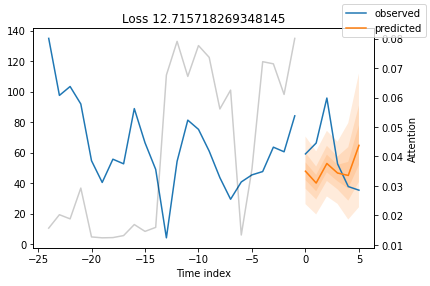

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
    break

### 2.1.4 Interpretation

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

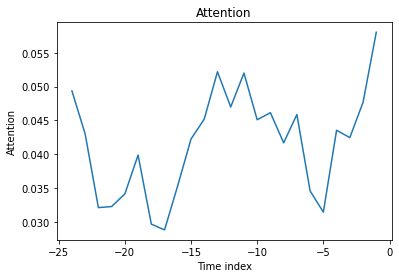

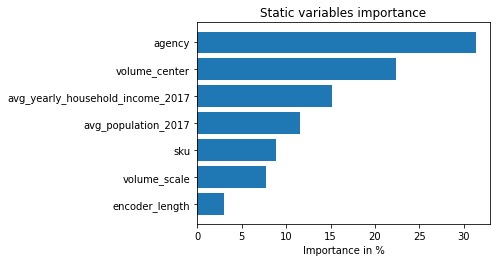

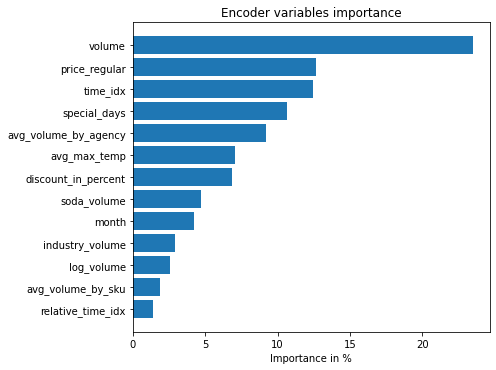

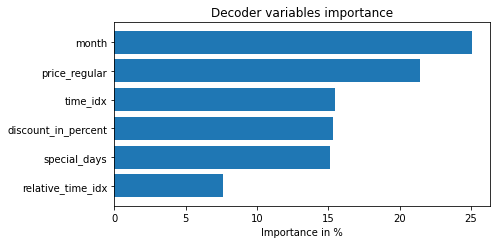

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

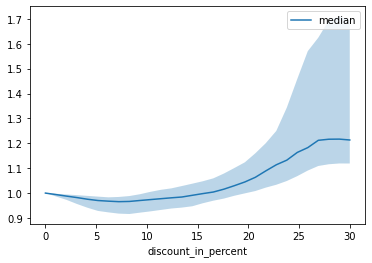

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

## 2.2 Building From Scratch

<img src='https://raw.githubusercontent.com/KalleBylin/temporal-fusion-transformers/main/img/tft_architecture.png'></img>

https://github.com/KalleBylin/temporal-fusion-transformers/blob/main/Temporal%20Fusion%20Transformer.ipynb

### 2.2.1 CONFIG

In [5]:
input_columns = [
    "power_usage", "days_from_start", "hours_from_start", 
    "categorical_day_of_week", "categorical_hour", "month", "categorical_id"
    ]

target_column = "power_usage"
entity_column = "categorical_id"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

params = {
    "quantiles": [0.1, 0.5, 0.9],
    "batch_size": 64,
    "dropout": 0.3,
    "device": "cuda",
    "hidden_layer_size": 128,
    "num_lstm_layers": 1,
    "embedding_dim": 8,
    "encoder_steps": 252,
    "num_attention_heads": 1, 
    "col_to_idx": col_to_idx, 
    "static_covariates": ["categorical_id"], 
    "time_dependent_categorical": ["categorical_day_of_week", "categorical_hour", "month"], 
    "time_dependent_continuous": ['power_usage', 'days_from_start', "hours_from_start",], 
    "category_nunique": {
        "categorical_day_of_week": 7, 
        "categorical_hour": 24, 
        "month": 9, 
        "categorical_id": 369, 
        }, 
    # known future variable
    "known_time_dependent": [
        "categorical_day_of_week", "categorical_hour", "month", 
        "days_from_start", "hours_from_start"
        ],
    # unknown future variable
    "observed_time_dependent": ["power_usage"]
}

### 2.2.2 Data Loading

In [4]:
df = pd.read_csv('hourly_electricity.csv')
df.head()

,Unnamed: 0,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,17544,2.538071,26304.0,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1,26304.0,2,0
1,17545,2.855330,26305.0,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1,26305.0,2,1
2,17546,2.855330,26306.0,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1,26306.0,2,2
3,17547,2.855330,26307.0,1096,MT_001,2014-01-01 03:00:00,MT_001,3,1,2,1,26307.0,2,3
4,17548,2.538071,26308.0,1096,MT_001,2014-01-01 04:00:00,MT_001,4,1,2,1,26308.0,2,4


In [ ]:
train = raw_data[raw_data['year'] < 2016]
valid = raw_data.loc[(raw_data['year'] >= 2016) & (raw_data['year'] < 2018)]
test = raw_data.loc[(raw_data['year'] >= 2018) & (raw_data.index <= '2019-06-28')]

In [ ]:
real_columns = ['log_vol', 'open_to_close', 'days_from_start']
categorical_columns = ['Symbol', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'Region']


def fit_preprocessing(train, real_columns, categorical_columns):
    real_scalers = StandardScaler().fit(train[real_columns].values)

    categorical_scalers = {}
    num_classes = []
    for col in categorical_columns:
        srs = train[col].apply(str) 
        categorical_scalers[col] = LabelEncoder().fit(srs.values)
        num_classes.append(srs.nunique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    out = df.copy()
    out[real_columns] = real_scalers.transform(df[real_columns].values)

    for col in categorical_columns:
        string_df = df[col].apply(str)
        out[col] = categorical_scalers[col].transform(string_df)

    return out


real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)
train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [ ]:
class TFT_Dataset(Dataset):
    def __init__(self, data, entity_column, time_column, target_column, 
                 input_columns, encoder_steps, decoder_steps):
        """
          data (pd.DataFrame): dataframe containing raw data
          entity_column (str): name of column containing entity data
          time_column (str): name of column containing date data
          target_column (str): name of column we need to predict
          input_columns (list): list of string names of columns used as input
          encoder_steps (int): number of known past time steps used for forecast. Equivalent to size of LSTM encoder
          decoder_steps (int): number of input time steps used for each forecast date. Equivalent to the width N of the decoder
        """
        
        self.encoder_steps = encoder_steps
             
        inputs = []
        outputs = []
        entity = []
        time = []

        for e in train[entity_column].unique():
          entity_group = data[data[entity_column]==e]
          
          data_time_steps = len(entity_group)

          if data_time_steps >= decoder_steps:
            x = entity_group[input_columns].values.astype(np.float32)
            inputs.append(np.stack([x[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            y = entity_group[[target_column]].values.astype(np.float32)
            outputs.append(np.stack([y[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            e = entity_group[[entity_column]].values.astype(np.float32)
            entity.append(np.stack([e[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            t = entity_group[[time_column]].values.astype(np.int64)
            time.append(np.stack([t[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

        self.inputs = np.concatenate(inputs, axis=0)
        self.outputs = np.concatenate(outputs, axis=0)[:, encoder_steps:, :]
        self.entity = np.concatenate(entity, axis=0)
        self.time = np.concatenate(time, axis=0)
        self.active_inputs = np.ones_like(outputs)

        self.sampled_data = {
            'inputs': self.inputs,
            'outputs': self.outputs[:, self.encoder_steps:, :],
            'active_entries': np.ones_like(self.outputs[:, self.encoder_steps:, :]),
            'time': self.time,
            'identifier': self.entity
        }
        
    def __getitem__(self, index):
        s = {
        'inputs': self.inputs[index],
        'outputs': self.outputs[index], 
        'active_entries': np.ones_like(self.outputs[index]), 
        'time': self.time[index],
        'identifier': self.entity[index]
        }

        return s

    def __len__(self):
        return self.inputs.shape[0]

training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
#validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
# valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

### 2.2.3 Gated Linear Unit & Gated Residual Network

Gated Residual Network blocks are among the main basic components of this network. They enable efficient information flow along with the skip connections and gating layers. The mechanisms allow the network to adapt both depth and complexity in order to perform well on a wide range of datasets and tasks.

* **Gated Linear Unit**. It is hard to know which variables are actually relevant for the prediction task from the outset. The gates of the Gated Linear Unit make it possible to suppress parts of the architecture that are not necessary in a particular scneario or with a specific dataset.

* **Temporal Layer** A wrapper that makes it possible to apply a layer to every temporal slice of an input. For example, it can be used to apply the same instance of a convolutional layer with the same set of weights on each timestep in the data. This TemporalLayer tries to collapse the tensor before passing it through the layer and then rebuilding the original shape before returning the resulting tensor.

* **Gated Residual Network** is a flexible block that can apply non-linear processing when required. The Gated Linear Unit defined above helps the GRN how much to contribute to its input and could potentially skip the layer altogether if necessary. GLU outputs close to 0 would supreess the non-linear contribution.

In [31]:
class GLU(nn.Module):
    """
      The Gated Linear Unit GLU(a, b) = mult(a,sigmoid(b)). 
      Sigmoid(b) corresponds to a gate that controls 
      what information from a is passed to the following layer. 

      Args:
          input_size (int): number defining input and output size of the gate
    """
    def __init__(self, input_size):
        super().__init__()
        
        self.a = nn.Linear(input_size, input_size)
        self.sigmoid = nn.Sigmoid()
        self.b = nn.Linear(input_size, input_size)
        
    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor passing through the gate
        """
        gate = self.sigmoid(self.b(x))
        x = self.a(x)
        return torch.mul(gate, x)

class TemporalLayer(nn.Module):
    def __init__(self, module):
        super().__init__()
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        """
        self.module = module

    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor with time steps to pass through the same layer.
        """
        t, n = x.size(0), x.size(1)
        x = x.reshape(t * n, -1)
        x = self.module(x)
        x = x.reshape(t, n, x.size(-1))
        return x

class GatedResidualNetwork(nn.Module):
    """
      The Gated Residual Network gives the model flexibility to apply non-linear
      processing only when needed. It is difficult to know beforehand which
      variables are relevant and in some cases simpler models can be beneficial.

      GRN(a, c) = LayerNorm(a + GLU(eta_1))
      eta_1 = W_1*eta_2 + b_1
      eta_2 = ELU(W_2*a + W_3*c + b_2)
      
      Args:
          input_size (int): Size of the input
          hidden_size (int): Size of the hidden layer
          output_size (int): Size of the output layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(
        self, 
        input_size, 
        hidden_size, 
        output_size, 
        dropout, 
        context_size=None, 
        is_temporal=True
        ):

        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.is_temporal = is_temporal
        
        if self.is_temporal:
            if self.input_size != self.output_size:
                self.skip_layer = TemporalLayer(nn.Linear(self.input_size, self.output_size))

            # Context vector c
            if self.context_size != None:
                self.c = TemporalLayer(nn.Linear(self.context_size, self.hidden_size, bias=False))

            # Dense & ELU
            self.dense1 = TemporalLayer(nn.Linear(self.input_size, self.hidden_size))
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = TemporalLayer(nn.Linear(self.hidden_size,  self.output_size))
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = TemporalLayer(GLU(self.output_size))
            self.layer_norm = TemporalLayer(nn.BatchNorm1d(self.output_size))

        else:
            if self.input_size != self.output_size:
                self.skip_layer = nn.Linear(self.input_size, self.output_size)

            # Context vector c
            if self.context_size != None:
                self.c = nn.Linear(self.context_size, self.hidden_size, bias=False)

            # Dense & ELU
            self.dense1 = nn.Linear(self.input_size, self.hidden_size)
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = nn.Linear(self.hidden_size,  self.output_size)
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = GLU(self.output_size)
            self.layer_norm = nn.BatchNorm1d(self.output_size)

    def forward(self, x, c=None):
        """
        Args:
            x (torch.tensor): tensor thas passes through the GRN
            c (torch.tensor): Optional static context vector
        """

        if self.input_size != self.output_size:
            a = self.skip_layer(x)
            print("test: ", a.size())
        else:
            a = x
        
        x = self.dense1(x)

        if c != None:
            c = self.c(c.unsqueeze(1))
            x += c

        eta_2 = self.elu(x)
        
        eta_1 = self.dense2(eta_2)
        eta_1 = self.dropout(eta_1)

        gate = self.gate(eta_1)
        gate += a
        x = self.layer_norm(gate)
        
        return x

### 2.2.4 Variable Selection Network

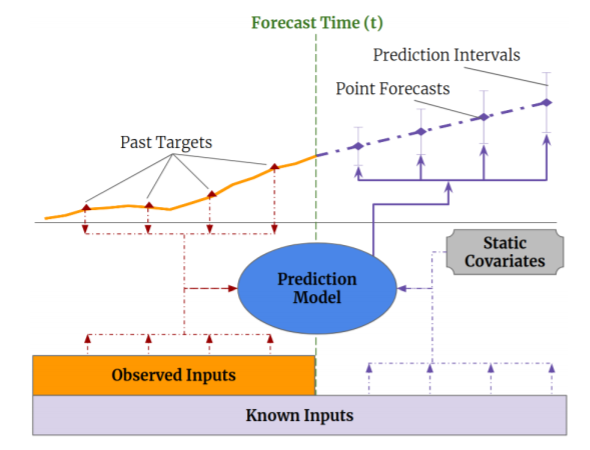

**Observed inputs** are time dependent variables that are known only up until t, point where forecasting of target starts. **Known inputs** are time dependent variables that can be known ahead of time (e.g. holidays, special events)

The Variable Selection Network makes it possible for the model to eliminate the noise raised from so many variables. It evaluates the most important variables for interpretability of the trained model.

In [32]:
class VariableSelectionNetwork(nn.Module):
    """
      The variable selection weights are created by feeding both the flattened
      vector of all past inputs at time t (E_t) and an optional context vector 
      through a GRN, followed by a Softmax layer.

      V_xt = Softmax(GRN_v(E_t, c_s)) 

      Also, the feature vector for each variable is fed through its 
      own GRN to create an additional layer of non-linear processing.

      Processed features are then weighted by the variable selection weights
      and combined.

      Args:
          input_size (int): Size of the input
          output_size (int): Size of the output layer
          hidden_size (int): Size of the hidden layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """

    def __init__(
        self, 
        input_size: int, 
        output_size: int, 
        hidden_size: int, 
        dropout: float, 
        context_size: int=None,
        is_temporal: bool=True
        ):

        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.context_size = context_size
        self.is_temporal = is_temporal
       
        self.flattened_inputs = GatedResidualNetwork(
            self.output_size*self.input_size, 
            self.hidden_size, self.output_size, 
            self.dropout, 
            self.context_size, 
            self.is_temporal
        )
        
        self.transformed_inputs = nn.ModuleList(
            [
                GatedResidualNetwork(
                    self.input_size, 
                    self.hidden_size, 
                    self.hidden_size, 
                    self.dropout, 
                    self.context_size, 
                    self.is_temporal
                    ) for i in range(self.output_size)
                ])

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedding, context=None):
        """
        Args:
          embedding (torch.tensor): Entity embeddings for categorical variables and linear 
                                    transformations for continuous variables.
          context (torch.tensor): obtained from a static covariate encoder and omitted 
                                  for static variables
        """

        # Generation of variable selection weights
        sparse_weights = self.flattened_inputs(embedding, context)

        if self.is_temporal:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(2)
        else:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(1)

        # Additional non-linear processing for each feature vector
        transformed_embeddings = torch.stack(
            [
                self.transformed_inputs[i](
                    embedding[Ellipsis, i*self.input_size:(i+1)*self.input_size]
                    ) for i in range(self.output_size)
                ], 
            axis=-1)

        # Processed features are weighted by their corresponding weights and combined
        combined = transformed_embeddings * sparse_weights
        combined = combined.sum(axis=-1)

        return combined, sparse_weights

### 2.2.5 Interpretable Multi-Head Attention

This particular block is used to learn long-term relationships from observed time-varying inputs. It is a modified version of the more general multi-head attention block used in transformer-based architectures, in order to improve explainability. It is well-known that the dot-product is a very simple but powerful tool to evaluate similarity between two vectors. For this same reason, it is also a great tool to help our model know what parts of the inputs to focus on based on the keys and queries. The scaling factor helps improve the performance of dot product attention by not allowing the softmax to move into regions with very small gradients.

Multi-head attention allows us to compute multiple attention computations in parallel on different projections of the keys, queries and values. This makes it possible for the model to leverage different types of information in the input which would otherwise be lost by the averaging effect in a single attention head. The original version fails in allowing us to be able to interpret the importance of each feature. The TFT proposes a modification of multi-head attention such that there are shared value weights among the different heads with an additive aggregation of the heads for better interpretability.



In [33]:
class ScaledDotProductAttention(nn.Module):
    """
    Attention mechansims usually scale values based on relationships between
    keys and queries. 
    
    Attention(Q,K,V) = A(Q,K)*V where A() is a normalization function.

    A common choice for the normalization function is scaled dot-product attention:

    A(Q,K) = Softmax(Q*K^T / sqrt(d_attention))

    Args:
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, query, key, value, mask=None):
        """
        Args:
          query (torch.tensor): 
          key (torch.tensor):
          value (torch.tensor): 
          mask (torch.tensor):
        """

        d_k = key.shape[-1]
        scaling_factor = torch.sqrt(torch.tensor(d_k).to(torch.float32))
        scaled_dot_product = torch.matmul(query, key.permute(0,2,1)) / scaling_factor 
        if mask != None:
            scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -1e9)
        attention = self.softmax(scaled_dot_product)
        attention = self.dropout(attention)
        output = torch.matmul(attention, value)

        return output, attention

class InterpretableMultiHeadAttention(nn.Module):
    """
    Different attention heads can be used to improve the learning capacity of 
    the model. 

    MultiHead(Q,K,V) = [H_1, ..., H_m]*W_H
    H_h = Attention(Q*Wh_Q, K*Wh_K, V*Wh_V)

    Each head has specific weights for keys, queries and values. W_H linearly
    combines the concatenated outputs from all heads.

    To increase interpretability, multi-head attention has been modified to share
    values in each head.

    InterpretableMultiHead(Q,K,V) = H_I*W_H
    H_I = 1/H * SUM(Attention(Q*Wh_Q, K*Wh_K, V*W_V)) # Note that W_V does not depend on the head. 

    Args:
          num_heads (int): Number of attention heads
          hidden_size (int): Hidden size of the model
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, hidden_size, num_attention_heads, dropout=0.0):
        super().__init__()

        self.num_attention_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        self.qs = nn.ModuleList(
            [
                nn.Linear(self.hidden_size, self.hidden_size, bias=False) 
                for i in range(self.num_attention_heads)
                ])
        
        self.ks = nn.ModuleList(
            [
                nn.Linear(self.hidden_size, self.hidden_size, bias=False) 
                for i in range(self.num_attention_heads)
                ])
        
        # Value is shared for improved interpretability
        vs_layer = nn.Linear(self.hidden_size, self.hidden_size, bias=False) 
        self.vs = nn.ModuleList([vs_layer for i in range(self.num_attention_heads)])
        self.attention = ScaledDotProductAttention()
        self.linear = nn.Linear(self.hidden_size, self.hidden_size, bias=False)

    def forward(self, query, key, value, mask=None):
        
        batch_size, tgt_len, embed_dim = query.shape
        head_dim = embed_dim // self.num_attention_heads

        # Now we iterate over each head to calculate outputs and attention
        heads = []
        attentions = []

        for i in range(self.num_attention_heads):
            q_i = self.qs[i](query)
            k_i = self.ks[i](key)
            v_i = self.vs[i](value)

            # Reshape q, k, v for multihead attention
            q_i = query\
                .reshape(batch_size, tgt_len, self.num_attention_heads, head_dim)\
                .transpose(1,2)\
                .reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)

            k_i = key\
                .reshape(batch_size, tgt_len, self.num_attention_heads, head_dim)\
                .transpose(1,2)\
                .reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)

            v_i = value\
                .reshape(batch_size, tgt_len, self.num_attention_heads, head_dim)\
                .transpose(1,2)\
                .reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)

            head, attention = self.attention(q_i, k_i, v_i, mask)

            # Revert to original target shape
            head = head.reshape(batch_size, self.num_attention_heads, tgt_len, head_dim)\
                .transpose(1,2)\
                .reshape(-1, tgt_len, self.num_attention_heads*head_dim)
                
            head_dropout = self.dropout(head)
            heads.append(head_dropout)
            attentions.append(attention)

        # Output the results
        if self.num_attention_heads > 1:
            heads = torch.stack(heads, dim=2) #.reshape(batch_size, tgt_len, -1, self.hidden_size)
            outputs = torch.mean(heads, dim=2)
        else:
            outputs = head

        attentions = torch.stack(attentions, dim=2)
        attention = torch.mean(attentions, dim=2)
        
        outputs = self.linear(outputs)
        outputs = self.dropout(outputs)

        return outputs, attention

### 2.2.6 TFT Architecture

In [38]:
class TemporalFusionTransformer(nn.Module):
    def __init__(self, parameters):

        super().__init__()

        # Inputs
        self.col_to_idx = parameters["col_to_idx"]
        self.static_covariates = parameters["static_covariates"] 
        self.time_dependent_categorical = parameters["time_dependent_categorical"]
        self.time_dependent_continuous = parameters["time_dependent_continuous"]
        self.category_nunique = parameters["category_nunique"]
        self.known_time_dependent = parameters["known_time_dependent"]
        self.observed_time_dependent = parameters["observed_time_dependent"]
        self.time_dependent = self.known_time_dependent + self.observed_time_dependent

        # Model Parameter
        self.batch_size = parameters['batch_size']
        self.encoder_steps = parameters['encoder_steps']
        self.hidden_size = parameters['hidden_layer_size']
        self.num_lstm_layers = parameters['num_lstm_layers']
        self.dropout = parameters['dropout']
        self.embedding_dim = parameters['embedding_dim']
        self.num_attention_heads = parameters['num_attention_heads']

        # Outputs
        self.quantiles = parameters['quantiles']
        self.device = parameters['device']

        # embeddings for the static covariates and static context vectors
        self.static_embeddings = nn.ModuleDict(
            {
                col: nn.Embedding(self.category_nunique[col], self.embedding_dim) 
                for col in self.static_covariates
             }) 
        
        self.static_variable_selection = VariableSelectionNetwork(
            self.embedding_dim, 
            len(self.static_covariates), 
            self.hidden_size, 
            self.dropout, 
            is_temporal=False
        ) 

        self.static_context_variable_selection = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout, 
            is_temporal=False
        )
        
        self.static_context_enrichment = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout, 
            is_temporal=False
            )
        
        self.static_context_state_h = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout, 
            is_temporal=False
            )
        
        self.static_context_state_c = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout, 
            is_temporal=False
            )
        
        # Prepare embeddings and linear transformations for time dependent variables
        self.temporal_cat_embeddings = nn.ModuleDict(
            {
                col: TemporalLayer(
                    nn.Embedding(self.category_nunique[col], self.embedding_dim)
                    ) for col in self.time_dependent_categorical
             })
        
        self.temporal_real_transformations = nn.ModuleDict(
            {
                col: TemporalLayer(
                    nn.Linear(1, self.embedding_dim)
                    ) for col in self.time_dependent_continuous
             })

        # Variable selection and encoder for past inputs
        self.past_variable_selection = VariableSelectionNetwork(
            self.embedding_dim, 
            len(self.time_dependent), 
            self.hidden_size, 
            self.dropout, 
            context_size=self.hidden_size
            )

        # Variable selection and decoder for known future inputs
        self.future_variable_selection = VariableSelectionNetwork(
            self.embedding_dim, 
            len([col for col in self.time_dependent if col not in self.observed_time_dependent]), 
            self.hidden_size, 
            self.dropout, 
            context_size=self.hidden_size
            )

        # LSTM encoder and decoder
        self.lstm_encoder = nn.LSTM(
            input_size=self.hidden_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_lstm_layers, 
            dropout=self.dropout
            )
        
        self.lstm_decoder = nn.LSTM(
            input_size=self.hidden_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_lstm_layers, 
            dropout=self.dropout
            )

        # Gated skip connection and normalization
        self.gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size))

        # Temporal Fusion Decoder
        # Static enrichment layer
        self.static_enrichment = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout, 
            self.hidden_size
            )
        
        # Temporal Self-attention layer
        self.multihead_attn = InterpretableMultiHeadAttention(
            self.num_attention_heads, 
            self.hidden_size
            )
        
        self.attention_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.attention_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        # Position-wise feed-forward layer
        self.position_wise_feed_forward = GatedResidualNetwork(
            self.hidden_size, 
            self.hidden_size, 
            self.hidden_size, 
            self.dropout
            )

        # Output layer
        self.output_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.output_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))
        self.output = TemporalLayer(nn.Linear(self.hidden_size, len(self.quantiles)))
        
    def define_static_covariate_encoders(self, x):
        embedding_vectors = [
            self.static_embeddings[col](x[:, 0, self.col_to_idx[col]].long().to(self.device)) 
            for col in self.static_covariates
            ]
            
        static_embedding = torch.cat(embedding_vectors, dim=1)
        static_encoder, static_weights = self.static_variable_selection(static_embedding)

        # Static context vectors
        # temporal variable selection
        static_context_s = self.static_context_variable_selection(static_encoder) 
        # static enrichment layer
        static_context_e = self.static_context_enrichment(static_encoder) 
        # local processing of temporal features (encoder/decoder)
        static_context_h = self.static_context_state_h(static_encoder) 
        # local processing of temporal features (encoder/decoder)
        static_context_c = self.static_context_state_c(static_encoder) 

        return (
            static_encoder, static_weights, static_context_s, 
            static_context_e, static_context_h, static_context_c)

    def define_past_inputs_encoder(self, x, context):
        embedding_vectors = torch.cat(
            [
                self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) 
                    for col in self.time_dependent_categorical
             ], dim=2)
        
        transformation_vectors = torch.cat(
            [
                self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) 
                    for col in self.time_dependent_continuous
             ], dim=2)

        past_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        past_encoder, past_weights = self.past_variable_selection(past_inputs, context)

        return past_encoder.transpose(0, 1), past_weights

    def define_known_future_inputs_decoder(self, x, context):
        embedding_vectors = torch.cat(
            [
                self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) 
                    for col in self.time_dependent_categorical if col not in self.observed_time_dependent
             ], dim=2)
        
        transformation_vectors = torch.cat(
            [
                self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) 
                    for col in self.time_dependent_continuous if col not in self.observed_time_dependent
             ], dim=2)

        future_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        future_decoder, future_weights = self.future_variable_selection(future_inputs, context)

        return future_decoder.transpose(0, 1), future_weights

    def define_lstm_encoder(self, x, static_context_h, static_context_c):
        output, (state_h, state_c) = self.lstm_encoder(
            x, 
            (
                static_context_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1), 
                static_context_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)
                ),
            )
        
        return output, state_h, state_c

    def define_lstm_decoder(self, x, state_h, state_c):
        output, (_, _) = self.lstm_decoder(
            x, 
            (
                state_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1), 
             state_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)
             )
            )
        
        return output

    def get_mask(self, attention_inputs):
        mask = torch.cumsum(
            torch.eye(
                attention_inputs.shape[0]*self.num_attention_heads, 
                attention_inputs.shape[1]
                ), 
            dim=1
            )

        return mask.unsqueeze(2).to(self.device)

    def forward(self, x):

        # Static variable selection and static covariate encoders
        static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c = self.define_static_covariate_encoders(x["inputs"])

        # Past input variable selection and LSTM encoder
        past_encoder, past_weights = self.define_past_inputs_encoder(
            x["inputs"][:, :self.encoder_steps, :].float().to(self.device), 
            static_context_s
            )

        # Known future inputs variable selection and LSTM decoder
        future_decoder, future_weights = self.define_known_future_inputs_decoder(
            x["inputs"][:, self.encoder_steps:, :].float().to(self.device), 
            static_context_s
            )
        
        # Pass output from variable selection through LSTM encoder and decoder
        encoder_output, state_h, state_c = self.define_lstm_encoder(
            past_encoder, 
            static_context_h, 
            static_context_c
            )
        
        decoder_output = self.define_lstm_decoder(
            future_decoder, 
            static_context_h, 
            static_context_c
            )

        # Gated skip connection before moving into the Temporal Fusion Decoder
        variable_selection_outputs = torch.cat([past_encoder, future_decoder], dim=0)
        lstm_outputs = torch.cat([encoder_output, decoder_output], dim=0)
        gated_outputs = self.gated_skip_connection(lstm_outputs)
        temporal_feature_outputs = self.add_norm(variable_selection_outputs.add(gated_outputs))
        temporal_feature_outputs = temporal_feature_outputs.transpose(0, 1)

        # Temporal Fusion Decoder

        # Static enrcihment layer
        static_enrichment_outputs = self.static_enrichment(
            temporal_feature_outputs, 
            static_context_e
            )

        # Temporal Self-attention layer
        mask = self.get_mask(static_enrichment_outputs)
        multihead_outputs, multihead_attention = self.multihead_attn(
            static_enrichment_outputs, 
            static_enrichment_outputs, 
            static_enrichment_outputs, 
            mask=mask
            )
        
        attention_gated_outputs = self.attention_gated_skip_connection(multihead_outputs)
        attention_outputs = self.attention_add_norm(
            attention_gated_outputs.add(static_enrichment_outputs)
            )

        # Position-wise feed-forward layer
        temporal_fusion_decoder_outputs = self.position_wise_feed_forward(attention_outputs)

        # Output layer
        gate_outputs = self.output_gated_skip_connection(temporal_fusion_decoder_outputs)
        norm_outputs = self.output_add_norm(gate_outputs.add(temporal_feature_outputs))

        output = self.output(norm_outputs[:, self.encoder_steps:, :]).view(-1,3)
        
        attention_weights = {
            'multihead_attention': multihead_attention,
            'static_weights': static_weights[Ellipsis, 0],
            'past_weights': past_weights[Ellipsis, 0, :],
            'future_weights': future_weights[Ellipsis, 0, :]
        }
        
        return  output, attention_weights

### testing
tft = TemporalFusionTransformer(params)
output, attention_weights = tft()